# Hotel Booking Cancellations Predictions

### Import all the libraries needed

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance

### Read the dataset using pandas read_csv

In [2]:
df = pd.read_csv('hotel_bookings.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


### Get the summary of all the data types in the dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

## 1. EDA (Exploratory Data Analysis)

### We are going to check how many types of hotels are there and which is more booked usually

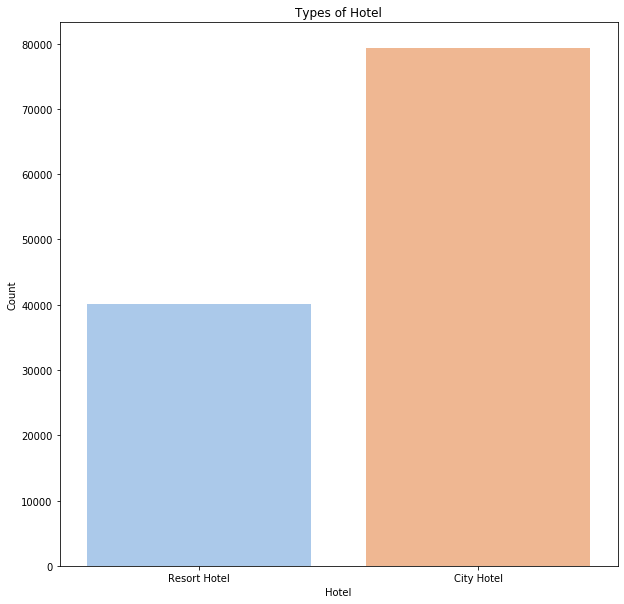

In [4]:
plt.figure(figsize=(10, 10))
sns.countplot(x='hotel', data=df, palette='pastel')
plt.title('Types of Hotel')
plt.xlabel('Hotel')
plt.ylabel('Count')
plt.show()

### We are going to check the amount of hotels that were canceled and not canceled

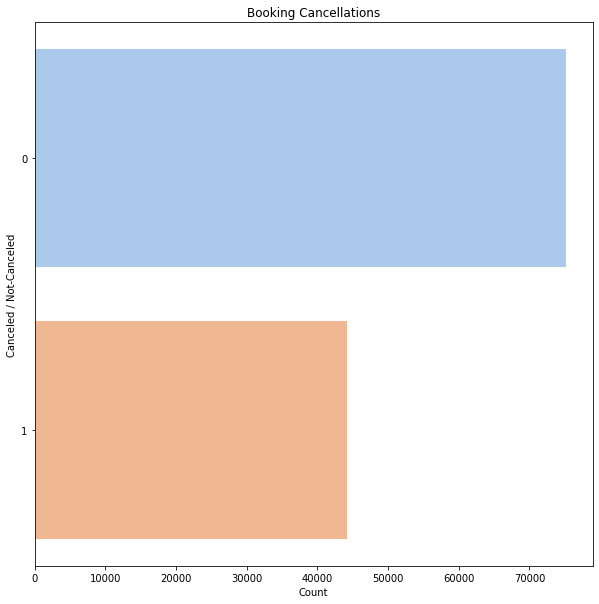

In [5]:
plt.figure(figsize=(10, 10))
sns.countplot(y='is_canceled', data=df, palette='pastel')
plt.title('Booking Cancellations')
plt.xlabel('Count')
plt.ylabel('Canceled / Not-Canceled')
plt.show()

### We are going to check how many guests came every month and we can also see if which month is most crowded with customers

In [6]:
# To make it easier to plot the data we are going to convert each month's format
df['arrival_date_month'].replace(
    {
        'January': '1',
        'February': '2',
        'March': '3',
        'April': '4',
        'May': '5',
        'June': '6',
        'July': '7',
        'August': '8',
        'September': '9', 
        'October': '10',
        'November': '11',
        'December': '12'
    }, inplace=True)

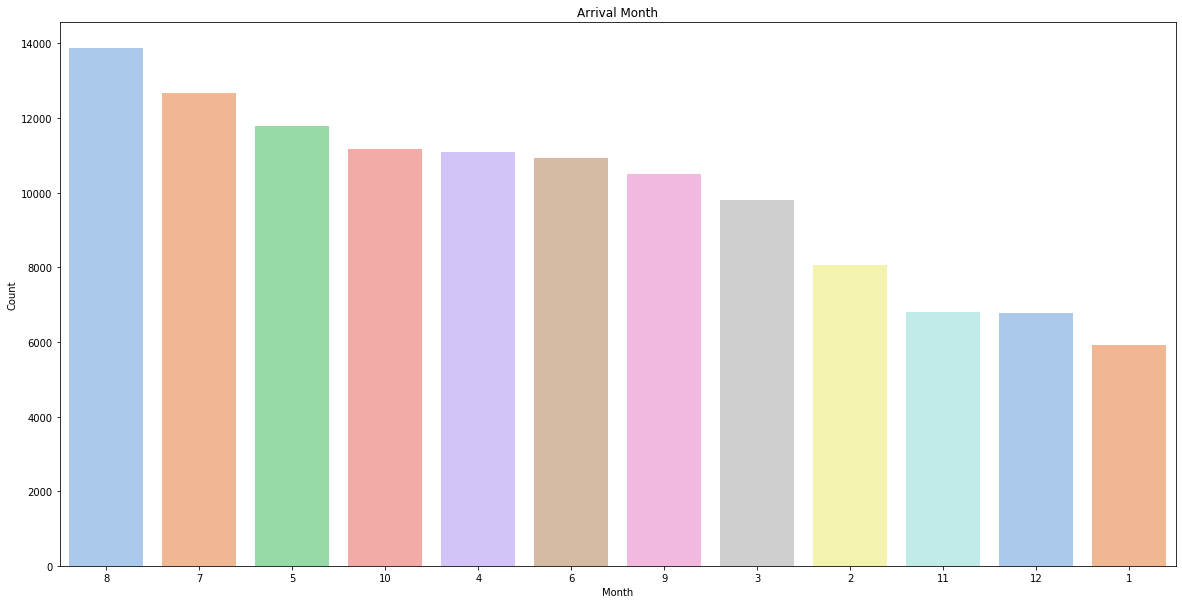

In [7]:
plt.figure(figsize=(20, 10))
sns.countplot(x='arrival_date_month', data=df, order=pd.value_counts(df['arrival_date_month']).index, palette='pastel')
plt.title('Arrival Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

### We are going to check where do most of our customers come from

In [8]:
cust_country = df[df['is_canceled'] == 0]['country'].value_counts().reset_index()
cust_country.columns = ['Country', 'Number of Guests']
cust_country

,Country,Number of Guests
0,PRT,21071
1,GBR,9676
2,FRA,8481
3,ESP,6391
4,DEU,6069
...,...,...
160,MDG,1
161,SYC,1
162,NAM,1
163,BHR,1


In [9]:
import folium
from folium.plugins import HeatMap
import plotly.express as px

basemap = folium.Map()
cust_map = px.choropleth(cust_country, locations=cust_country['Country'], color=cust_country['Number of Guests'],hover_name = cust_country['Country'])
cust_map.show()

### We are going to check how many adults, adults with children, adults with babies, and adults with children and babies book the hotel

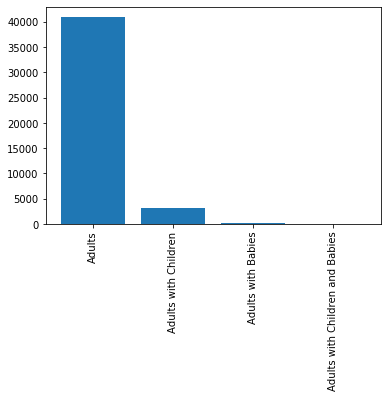

In [10]:
names = ['Adults', 'Adults with Children', 'Adults with Babies', 'Adults with Children and Babies']
adults_children_babies = len(df[(df['children'] != 0) & (df['babies'] != 0) & (df['is_canceled'] == 1)])
adults_children = len(df[(df['children'] != 0) & (df['is_canceled'] == 1)]) - adults_children_babies
adults_babies = len(df[(df['babies'] != 0) & (df['is_canceled'] == 1)]) - adults_children_babies
adults = len(df[df['is_canceled'] == 1]) - adults_children_babies - adults_children - adults_babies
values = [adults, adults_children, adults_babies, adults_children_babies]

plt.bar(names, values)
plt.xticks(rotation=90)
plt.show()

### We are going to check where do our customers book their hotels from

Text(0, 0.5, 'Count')

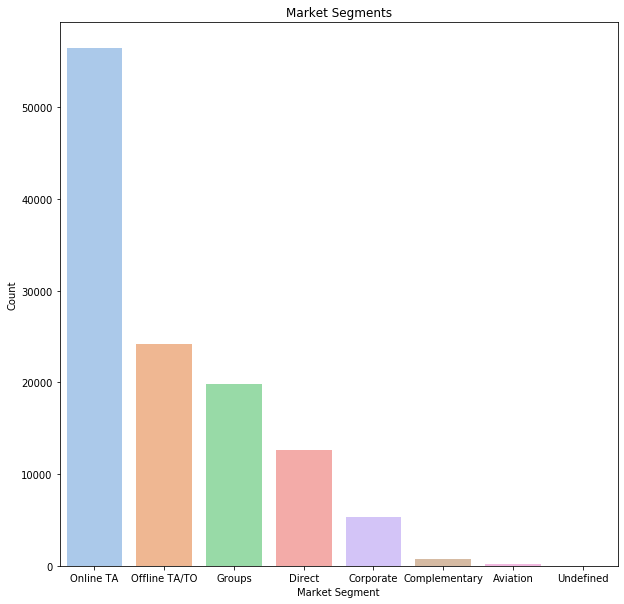

In [11]:
plt.figure(figsize=(10,10))
sns.countplot(df['market_segment'], palette='pastel', order=pd.value_counts(df['market_segment']).index)
plt.title('Market Segments')
plt.xlabel('Market Segment')
plt.ylabel('Count')

### We are going to check if a booking getting canceled has any connection with special requests made during booking

Text(0, 0.5, 'Bookings')

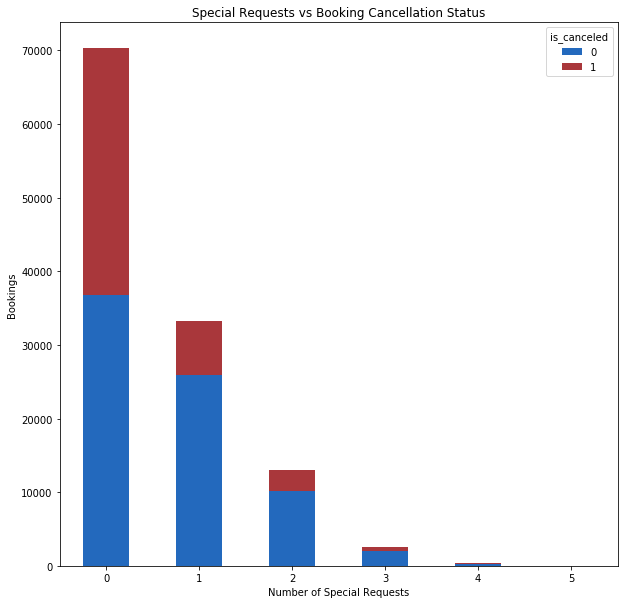

In [12]:
specialRequest = df.groupby([ 'total_of_special_requests', 'is_canceled']).size().unstack(fill_value=0)
specialRequest.plot(kind='bar', stacked=True, cmap='vlag', figsize=(10,10))
plt.title('Special Requests vs Booking Cancellation Status')
plt.xlabel('Number of Special Requests')
plt.xticks(rotation=360)
plt.ylabel('Bookings')

## Preprocessing 

### The first thing we are going to do here is check for null values in the dataset

In [13]:
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

#### In the results above we can see that we have 4 columns with null value (children, country, agent, and company). 

We can see that Company has 112593 null values, which is around 94% of the data. So, if we drop Company it won't be much of a problem. 

Filling the null values for the column children with 0 won't be a problem because we can assume they have 0 children. 

Filling the null values for the column agent with 0 because we can assume they are not a registered agent.

Filling the column country as other.

In [14]:
df = df.drop(['company'], axis = 1)
df['children'] = df['children'].fillna(0)
df['agent'] = df['agent'].fillna(0)
df["country"].fillna("OTHER", inplace = True)

### We are going to seperate categorical and numerical features so that we can see which columns are categorical and needed to be encoded so that the training process runs smoothly

In [15]:
categorical_features = df.dtypes == object
cat_features = df.columns[categorical_features].tolist()
categorical_data = df[cat_features]
categorical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   hotel                    119390 non-null  object
 1   arrival_date_month       119390 non-null  object
 2   meal                     119390 non-null  object
 3   country                  119390 non-null  object
 4   market_segment           119390 non-null  object
 5   distribution_channel     119390 non-null  object
 6   reserved_room_type       119390 non-null  object
 7   assigned_room_type       119390 non-null  object
 8   deposit_type             119390 non-null  object
 9   customer_type            119390 non-null  object
 10  reservation_status       119390 non-null  object
 11  reservation_status_date  119390 non-null  object
dtypes: object(12)
memory usage: 10.9+ MB


#### We have a total of 12 categorical columns and needed to be encoded

In [16]:
numerical_features = df.select_dtypes(include='number')
numerical_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 19 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     119390 non-null  int64  
 1   lead_time                       119390 non-null  int64  
 2   arrival_date_year               119390 non-null  int64  
 3   arrival_date_week_number        119390 non-null  int64  
 4   arrival_date_day_of_month       119390 non-null  int64  
 5   stays_in_weekend_nights         119390 non-null  int64  
 6   stays_in_week_nights            119390 non-null  int64  
 7   adults                          119390 non-null  int64  
 8   children                        119390 non-null  float64
 9   babies                          119390 non-null  int64  
 10  is_repeated_guest               119390 non-null  int64  
 11  previous_cancellations          119390 non-null  int64  
 12  previous_booking

#### We have a total of 19 numerical columns

### The next step is to encode categorical features using the LabelEncoder library

In [17]:
le = LabelEncoder()
df[cat_features] = df[cat_features].apply(lambda col: le.fit_transform(col))
categorical_df = df[cat_features]
categorical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype
---  ------                   --------------   -----
 0   hotel                    119390 non-null  int64
 1   arrival_date_month       119390 non-null  int64
 2   meal                     119390 non-null  int64
 3   country                  119390 non-null  int64
 4   market_segment           119390 non-null  int64
 5   distribution_channel     119390 non-null  int64
 6   reserved_room_type       119390 non-null  int64
 7   assigned_room_type       119390 non-null  int64
 8   deposit_type             119390 non-null  int64
 9   customer_type            119390 non-null  int64
 10  reservation_status       119390 non-null  int64
 11  reservation_status_date  119390 non-null  int64
dtypes: int64(12)
memory usage: 10.9 MB


#### To avoid overfitting, we are going to drop reservation_status because it's completely the same with is_canceled and we are just going to focus on is_canceled as our target

In [18]:
df = df.drop(['reservation_status'], axis=1)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  int64  
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  int64  
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119390 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

### Here we are splitting our dataset into X and y, X for our features and y for our target

In [20]:
X = df.drop(['is_canceled'], axis = 1)
y = df['is_canceled']

#### Splitting our dataset into Training & Testing. We are going to use 70% for testing and 30% for training.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### After splitting our dataset into training & testing, we are going to scale the dataset so that the values aren't too big and will consume less time computing

In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [23]:
X_train_scaled

array([[ 1.41002307,  0.16924303, -0.220692  , ..., -0.25431595,
         1.80455937,  0.52424723],
       [-0.70920826, -0.7852072 , -1.63369224, ..., -0.25431595,
        -0.72137945, -1.66832628],
       [-0.70920826, -0.1582644 ,  1.19230825, ..., -0.25431595,
        -0.72137945,  1.16136778],
       ...,
       [-0.70920826, -0.27991002, -0.220692  , ..., -0.25431595,
        -0.72137945,  0.66924708],
       [ 1.41002307,  0.24410187, -1.63369224, ..., -0.25431595,
         1.80455937, -1.90559877],
       [ 1.41002307, -0.82263662, -1.63369224, ..., -0.25431595,
         0.54158996, -1.59802332]])

### Here we are going to use RFECV (Recursive Feature Elimination using Cross Validation) for our Feature Selection.

#### RFE basically wraps a machine learning method and helps in selecting features. It fits the given machine learning algorithm (in our case we are going to use XGBClassifier) and ranks feature importance and repeats until the desired number of features are successfully computed.

#### RFECV gives us the ability to automatically select all the important features. We just have to give minimum number of features to select (if not the default value 1 will be assigned). 

In [24]:
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier

rfecv = RFECV(
    estimator=XGBClassifier(),
    min_features_to_select=5,
    step=5,
    n_jobs=-1,
    scoring="r2",
    cv=5,
)

_ = rfecv.fit(X_train_scaled, y_train)

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[02:32:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your lab

#### RFECV has the .support attribute which tells us which columns has it selected

In [25]:
X_train.columns[rfecv.support_]

Index(['hotel', 'lead_time', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status_date'],
      dtype='object')

### I have used SGDClassifier, XGBClassifier, ExtraTreeClassifier, and RandomForestClassifier for comparing. As we can see above XGBClassifier gives us the highest accuracy of 97.5%

In [26]:
from sklearn.linear_model import SGDClassifier

model = SGDClassifier()
model.fit(X_train_scaled, y_train)
prediction = model.predict(X_test_scaled)

In [27]:
sgd_accuracy = accuracy_score(y_test, prediction)
sgd_accuracy

0.9354217271128236

In [28]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()
xgb_model.fit(X_train_scaled, y_train)
xgb_prediction = xgb_model.predict(X_test_scaled)

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[02:33:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [29]:
xgb_accuracy = accuracy_score(y_test, xgb_prediction)
xgb_accuracy

0.9757656978529748

In [30]:
from sklearn.ensemble import ExtraTreesClassifier

etc = ExtraTreesClassifier()
etc.fit(X_train_scaled, y_train)
etc_prediction = etc.predict(X_test_scaled)

In [31]:
etc_accuracy = accuracy_score(y_test, etc_prediction)
etc_accuracy

0.9397772007705838

In [32]:
rfc = RandomForestClassifier()
rfc.fit(X_train_scaled, y_train)
rfc_pred = rfc.predict(X_test_scaled)

In [33]:
rfc_accuracy = accuracy_score(y_test, rfc_pred)
rfc_accuracy

0.9469804841276489

### Confusion Matrix for all the methods used above

(0, 2)

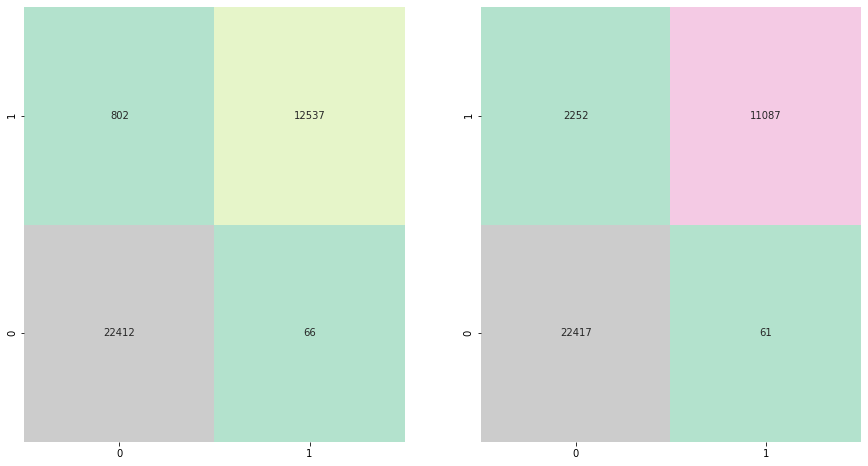

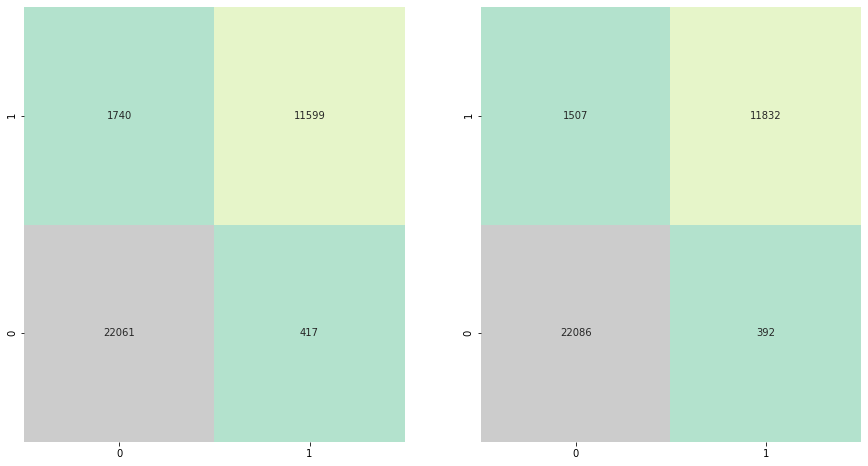

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
xgb_cm = confusion_matrix(y_test, xgb_prediction)
sgd_cm = confusion_matrix(y_test, prediction)
fig, axe = plt.subplots(1, 2, figsize=(15, 8))
etc_cm = confusion_matrix(y_test, etc_prediction)
rfc_cm = confusion_matrix(y_test, rfc_pred)

sns.heatmap(xgb_cm, annot=True, fmt="d", cbar=False, cmap="Pastel2",  ax = ax[0]).set_ylim([0,2])
sns.heatmap(sgd_cm, annot=True, fmt="d", cbar=False, cmap="Pastel2",  ax = ax[1]).set_ylim([0,2])
sns.heatmap(etc_cm, annot=True, fmt="d", cbar=False, cmap="Pastel2",  ax = axe[0]).set_ylim([0,2])
sns.heatmap(rfc_cm, annot=True, fmt="d", cbar=False, cmap="Pastel2",  ax = axe[1]).set_ylim([0,2])